# Segment Anything in Medical Images ([colab](https://colab.research.google.com/drive/1N4wv9jljtEZ_w-f92iOLXCdkD-KJlsJH?usp=sharing))
Segmentation is a fundamental task in medical imaging analysis. Deep learning-based models have shown great promise in medical image segmentation due to their ability to learn intricate image features and deliver accurate segmentation results across a diverse range of tasks. Recently, the Segmentation Anything Model (SAM) has shown remarkable versatility and performance in natural image segmentation. However, their application to medical image segmentation has been challenging due to the substantial domain gap. In this tutorial, we will introduce how to adapt the SAM's success to medical image segmentation.

## Overview

0. Installation
1. Methodology introduction
2. Load pre-trained model
3. Load data and run inference in an interactive way
4. Others
   - a. Fine-tuning with customized datasets
   - b. Medical image segmentation with text-based prompts
   - c. Medical image segmentation with point-based prompts

## Installation is super easy. 
On the local device:
- Create a fresh environment `conda create -n medsam python=3.10 -y` and activate it `conda activate medsam`
- Install [pytorch 2.0](https://pytorch.org/get-started/locally/)
- Run the following command.

If you are using Colab, you can directly run the following command. 

In [1]:
%timeit import skimage.io

The slowest run took 13.33 times longer than the fastest. This could mean that an intermediate result is being cached.
900 ns ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
#!pip install git+https://github.com/bowang-lab/MedSAM.git
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
import skimage
import skimage.io
from skimage import transform
# # 
#from skimage import io, transform
from segment_anything import sam_model_registry
from tabulate import tabulate

import torch.nn.functional as F

In [3]:
#import numpy as np

In [1]:
# #%conda create -n medsam python=3.10
# try:
#     import skimage
#     print("scikit-image (skimage) is installed.")
# except ImportError:
#     print("scikit-image (skimage) is not installed.")

import sys
print(sys.prefix)


C:\Users\cinth\anaconda3\envs\medsam


In [5]:
import sys
import torch

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)


Python version: 3.10.14 | packaged by Anaconda, Inc. | (main, Mar 21 2024, 16:20:14) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.0.0


In [6]:
import sys
import torch

print(sys.executable)


torch.cuda.get_arch_list()


C:\Users\cinth\anaconda3\envs\medsam\python.exe


['sm_37',
 'sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'sm_90',
 'compute_37']

In [7]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print("CUDA version:", cuda_version)
else:
    print("CUDA is not available on this system.")


CUDA version: 11.8


## 1. Methodology introduction

SAM is a promptable segmentation model and it supports three types of prompts: bounding box, point, and text. (Note: The text-prompt function in SAM is not publicly available.) While the concept of fully automatic medical image segmentation foundation models is enticing, it is fraught with challenges that make it impractical. One of the primary challenges is the variability inherent in segmentation tasks. For example, given a liver cancer CT image, the segmentation task can vary depending on the specific clinical scenario. One clinician might be interested in segmenting the liver tumor, while another might need to segment the entire liver and surrounding organs. Additionally, the variability in imaging modalities presents another challenge. Modalities such as CT and MR generate 3D images, whereas others like X-Ray and ultrasound yield 2D images. These variabilities in task definition and imaging modalities complicate the design of a fully automatic model capable of accurately anticipating and addressing the diverse requirements of different users.

Considering these challenges, we argue that a more practical approach is to develop a promptable 2D model for general medical image segmentation. The model can be easily adapted to specific tasks based on user-provided prompts, offering enhanced flexibility and adaptability. It is also able to handle both 2D and 3D images by processing 3D images as a series of 2D slices. Compared to point-based and text-based prompts, the bounding box-based prompt has three main advantages: 1) it has less ambiguity and can clearly specify the ROI with minor user intervention (clicking on the top left and bottom right points); 2) it doesn't require multiple trial and error; 3) it can be seamlessly integrated into tumor measurements (e.g., Response Evaluation Criteria In Solid Tumors [RECIST](https://radiologyassistant.nl/more/recist-1-1/recist-1-1)) by simulating bounding box from the linear annotation (e.g., long axis and short axis).  


In order to use the pre-trained weights, we follow SAM's network architecture in SAM, including an image encoder, a prompt encoder, and a mask decoder. The image encoder maps the input image into a high-dimensional image embedding space. The prompt encoder transforms the user-drawn bounding boxes into feature representations via positional encoding. Finally, the mask decoder fuses the image embedding and prompt features using cross-attention. It should be noted that the image embedding only needs to be computed once during inference. Then, one can draw different bounding boxes to segment different targets in real-time. 

![network](assets/architecture.png)

## 2. Load pre-trained model

Please download the checkpoint [here](https://drive.google.com/drive/folders/1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN?usp=drive_link). This pre-trained model can be directed loaded with SAM's checkpoint loader. 

In [8]:
%matplotlib widget
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
import os

# Define the checkpoint path
checkpoint_folder = '.\work_dir\MedSAM\medsam_vit_b'
checkpoint_file = 'medsam_vit_b.pth'
MedSAM_CKPT_PATH = os.path.join(checkpoint_folder, checkpoint_file)

device = "cuda:0"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [9]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()


# Print the result
print("CUDA available:", cuda_available)

# Get the device
device = torch.device("cuda:0" if cuda_available else "cpu")

# Print the device
print("Device:", device)


CUDA available: True
Device: cuda:0


In [10]:
# # import os
# # 
# # # Replace 'path_to_file_or_directory' with the actual path
# # file_path = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\medsam_vit_b'
# # 
# # # Check if the file exists
# # if os.path.exists(file_path):
# #     # Check the file permissions
# #     access_rights = os.access(file_path, os.R_OK), os.access(file_path, os.W_OK), os.access(file_path, os.X_OK)
# #     print("Read permission:", access_rights[0])
# #     print("Write permission:", access_rights[1])
# #     print("Execute permission:", access_rights[2])
# # else:
# #     print("File does not exist.")
# print("Model's device:", next(medsam_model.parameters()).device)


## 3. Load data and run inference in an interactive way

One can directly draw the bounding box to segment the targets. Here are two examples of the abdomen CT image and colon gland pathology image. 
Please use relatively tight bounding boxes since the model was not trained with large bounding box perturbations. 

![abdomen CT](assets/seg_demo.gif)

In [11]:


# _file = 'medsam_vit_b.pth'
# MedSAM_CKPT_PATH = os.path.join(checkpoint_folder, checkpoint_file)


In [12]:
# import skimage.io as io
# 
# 
# image_path = ('.\\assets\\20190830T115515_9.png')
# mask_path = ".\\assets\\20190830T115515_9_mask.png"
# 
# input_image = io.imread(image_path)
# ground_truth_mask = io.imread(mask_path)


In [13]:
# @torch.no_grad()
# def medsam_inference(medsam_model, img_embed, box_1024, H, W):
#     box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
#     if len(box_torch.shape) == 2:
#         box_torch = box_torch[:, None, :] # (B, 1, 4)
# 
#     sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
#         points=None,
#         boxes=box_torch,
#         masks=None,
#     )
#     # Rest of the code...


In [14]:
# # Visualize the segmentation result
# plt.imshow(medsam_seg, cmap='gray')
# plt.title('Segmentation Result')
# plt.show()


In [15]:
#from PIL import Image
# two hours until 4 pm
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg



In [16]:
# import os
# medsam_folder = r'.\assets'
# img_demo = ('.\\assets\\20190830T115515_9.png')
# #C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\assets\20190830T115515_9.png
# 
# img_np = io.imread(img_demo)
# if len(img_np.shape) == 2:
#     img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
# else:
#     img_3c = img_np
# H, W, _ = img_3c.shape

In [17]:
# # # abdomen CT
# # import cv2
# import os
# medsam_folder = r'.\assets'
# img_demo =  ('.\\20190911T104437_549.png')
# # 
# img = os.path.join(medsam_folder, img_demo)
# # # image = cv2.imread(img)
# # # cv2.imshow('Image', image)
# # # cv2.waitKey(0)
# # # cv2.destroyAllWindows()
# # 
# bbox_prompt_demo = BboxPromptDemo(medsam_model)
# bbox_prompt_demo.show(img)

## 4. Others

Now, we have shown how to use MedSAM to segment medical images by drawing bounding boxes. We also provide advanced tutorials to show 
   - a. How was MedSAM trained? or How to fine-tune SAM on customized datasets? [training](https://github.com/bowang-lab/MedSAM/tree/main#model-training)
   - b. How to fine-tune the model with text-based prompts: [training](https://github.com/bowang-lab/MedSAM/tree/main/extensions/text_prompt) and [inference colab](https://colab.research.google.com/drive/1wexPLewVMI-9EMiplfyoEtGGayYDH3tt?usp=sharing) 
   - c. How to fine-tune the model with point-based prompts: [training](https://github.com/bowang-lab/MedSAM/tree/main/extensions/point_prompt) and [inference colab](https://colab.research.google.com/drive/1cCBw_IhdPiWE4sN7QwqKJPgAFlWsKgkm?usp=sharing)

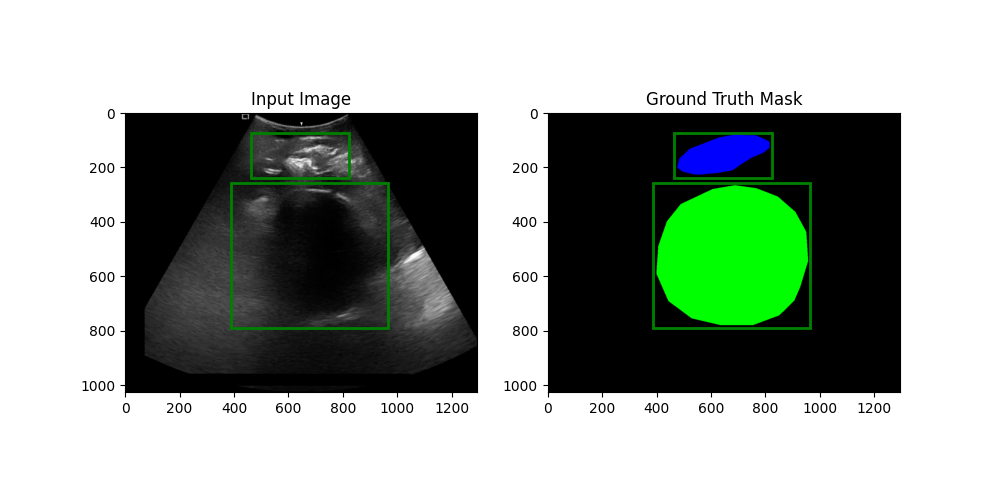

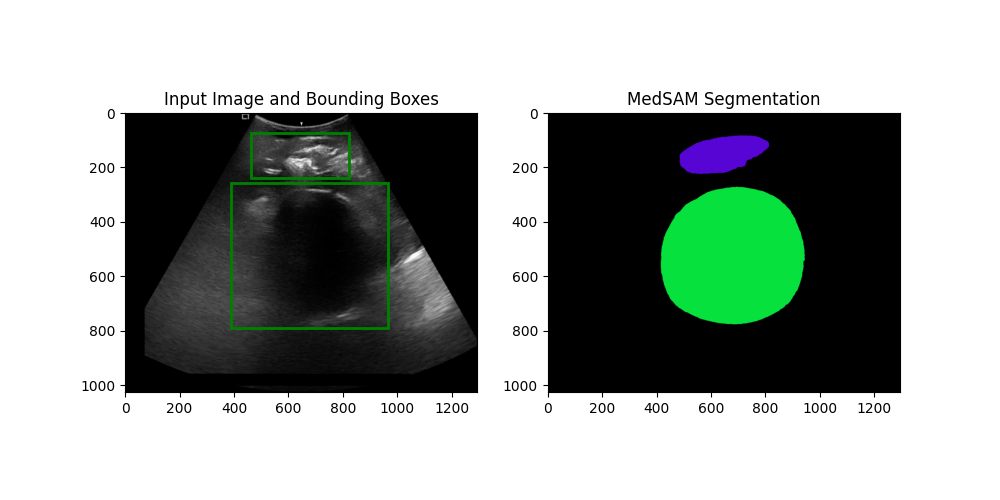

In [18]:
import cv2
import numpy as np
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Load your image
image = cv2.imread('.\\assets\\20190911T104437_549.png')

# Load ground truth data
ground_truth = cv2.imread('.\\assets\\20190911T104437_549_mask.png')
# # Initialize an empty mask with the same shape as the input image
img_3c_with_mask = np.zeros_like(image)
# Convert ground truth mask to grayscale 
ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY) #used for scores

# Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
_, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Input Image")

# Overlay ground truth mask on input image
ax[1].imshow(ground_truth)
ax[1].set_title("Ground Truth Mask")

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Draw bounding box on input image
    rect1 = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect1)

    # Draw bounding box on ground truth mask
    rect2 = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    ax[1].add_patch(rect2)

plt.show()

# Load your image
# image = cv2.imread('.\\assets\\20190830T115515_9.png')
image = cv2.imread('.\\assets\\20190911T104437_549.png')

# Load ground truth data
# ground_truth = cv2.imread('.\\assets\\20190830T115515_9_mask.png')
ground_truth = cv2.imread('.\\assets\\20190911T104437_549_mask.png')

# Convert ground truth mask to grayscale
ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
_, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Input Image")

# Overlay ground truth mask on input image
ax[1].imshow(ground_truth)
ax[1].set_title("Ground Truth Mask")

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Convert the expanded bounding box coordinates to the format used in MedSAM (x_min, y_min, x_max, y_max)
    box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])

    if len(image.shape) == 2:
        img_3c = np.repeat(image[:, :, None], 3, axis=-1)
    else:
        img_3c = image
    H, W, _ = img_3c.shape
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # Transfer box_np to 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W) #used for scores

    # Draw bounding box on input image
    rect1 = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect1)

    # Overlay segmentation mask on input image with random colors
    colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
    unique_labels = np.unique(medsam_seg)
    for label in unique_labels:
        if label == 0:
            continue
        mask = np.zeros_like(medsam_seg)
        mask[medsam_seg == label] = 255
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        color = random.choice(colors)
        mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
        img_3c_with_mask += mask_rgb
    ax[1].imshow(img_3c_with_mask)

ax[0].set_title("Input Image and Bounding Boxes")
ax[1].set_title("MedSAM Segmentation")

plt.show()


## Visualizations per image

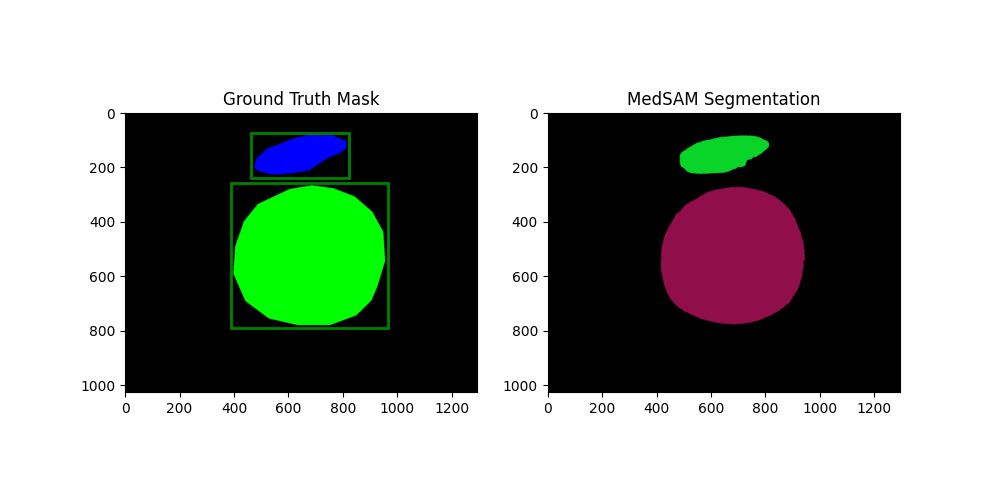

In [19]:
import cv2
import numpy as np
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Overlay ground truth mask on input image
ax[0].imshow(ground_truth)
ax[0].set_title("Ground Truth Mask")

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Draw bounding box on ground truth mask
    rect = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)

# Load your image (You may need to replace this part with your actual code for loading the image)
image = cv2.imread('.\\assets\\20190911T104437_549.png')

# Load ground truth data (You may need to replace this part with your actual code for loading the ground truth data)
ground_truth = cv2.imread('.\\assets\\20190911T104437_549_mask.png')

# # Initialize an empty mask with the same shape as the input image
img_3c_with_mask = np.zeros_like(image)
# Convert ground truth mask to grayscale (You may need to replace this part with your actual code for processing the ground truth mask)
ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale mask to separate green areas (ROI) from black areas (background) (You may need to replace this part with your actual code for processing the ground truth mask)
_, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

# Find contours in the mask (You may need to replace this part with your actual code for processing the ground truth mask)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Convert the expanded bounding box coordinates to the format used in MedSAM (x_min, y_min, x_max, y_max)
    box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])

    if len(image.shape) == 2:
        img_3c = np.repeat(image[:, :, None], 3, axis=-1)
    else:
        img_3c = image
    H, W, _ = img_3c.shape
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    #print("Using device:", device) .. using cuda

    # Transfer box_np to 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W) #used for scores

    # Overlay segmentation mask on input image with random colors
    colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
    unique_labels = np.unique(medsam_seg)
    for label in unique_labels:
        if label == 0:
            continue
        mask = np.zeros_like(medsam_seg)
        mask[medsam_seg == label] = 255
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        color = random.choice(colors)
        mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
        img_3c_with_mask += mask_rgb
    ax[1].imshow(img_3c_with_mask)

ax[1].set_title("MedSAM Segmentation")

plt.show()


    ## All dataset

## Changing names

#### CHANGING NAMES MASKS

## Partition of images only

1. download dataset again.. copy 
2. try indexing
3. try partition with indexing
4. try segmenting like that.. check for bounding boxes and more adjustments
5. get scores

## Partition with putting masks in respective folder


In [20]:
# import os
# import random
# import shutil
# 
# # Define input and output folders
# input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\us_data'
# output_folder_images = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\images'
# output_folder_masks = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\masks'
# 
# os.makedirs(output_folder_images, exist_ok=True)
# os.makedirs(output_folder_masks, exist_ok=True)
# 
# # Define proportions for training, validation, and testing sets (as fractions)
# train_ratio = 0.6
# val_ratio = 0.2
# test_ratio = 0.2
# 
# # Create output folders for training, validation, and testing sets
# train_folder_images = os.path.join(output_folder_images, 'train')
# val_folder_images = os.path.join(output_folder_images, 'val')
# test_folder_images = os.path.join(output_folder_images, 'test')
# train_folder_masks = os.path.join(output_folder_masks, 'train')
# val_folder_masks = os.path.join(output_folder_masks, 'val')
# test_folder_masks = os.path.join(output_folder_masks, 'test')
# os.makedirs(train_folder_images, exist_ok=True)
# os.makedirs(val_folder_images, exist_ok=True)
# os.makedirs(test_folder_images, exist_ok=True)
# os.makedirs(train_folder_masks, exist_ok=True)
# os.makedirs(val_folder_masks, exist_ok=True)
# os.makedirs(test_folder_masks, exist_ok=True)
# 
# # Function to copy images and masks while conserving names
# def copy_images_and_masks(images, masks, src_image_folder, src_mask_folder, dest_image_folder, dest_mask_folder):
#     for idx, (image_name, mask_name) in enumerate(zip(images, masks)):
#         src_image_path = os.path.join(src_image_folder, image_name)
#         src_mask_path = os.path.join(src_mask_folder, mask_name)
#         
#         # Define the destination image and mask paths
#         dest_image_path = os.path.join(dest_image_folder, image_name)
#         dest_mask_path = os.path.join(dest_mask_folder, mask_name)
#         
#         # Copy images and masks to corresponding output folders while conserving names
#         shutil.copyfile(src_image_path, dest_image_path)
#         shutil.copyfile(src_mask_path, dest_mask_path)
# 
# # Traverse through each video folder
# for video_folder in os.listdir(input_folder):
#     video_folder_path = os.path.join(input_folder, video_folder)
#     if os.path.isdir(video_folder_path):
#         # Look for the 'mask_enhance' folder within each video folder
#         mask_enhance_folder = os.path.join(video_folder_path, 'mask_enhance')
#         if os.path.exists(mask_enhance_folder):
#             # List image and mask filenames
#             images = os.listdir(os.path.join(video_folder_path, 'image'))
#             masks = os.listdir(mask_enhance_folder)
#             
#             # Shuffle both lists in the same order
#             combined = list(zip(images, masks))
#             random.shuffle(combined)
#             images_shuffled, masks_shuffled = zip(*combined)
#             
#             # Convert tuples to lists
#             images_shuffled = list(images_shuffled)
#             masks_shuffled = list(masks_shuffled)
#             
#             # Sort images and masks based on numerical index
#             images_shuffled.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
#             masks_shuffled.sort(key=lambda x: int(x.split('_')[-2]))
#             
#             # Calculate the number of images for each set
#             num_train = int(train_ratio * len(images_shuffled))
#             num_val = int(val_ratio * len(images_shuffled))
#             num_test = len(images_shuffled) - num_train - num_val
#             
#             # Partition images and masks into training, validation, and testing sets
#             train_images = images_shuffled[:num_train]
#             val_images = images_shuffled[num_train:num_train+num_val]
#             test_images = images_shuffled[num_train+num_val:]
#             train_masks = masks_shuffled[:num_train]
#             val_masks = masks_shuffled[num_train:num_train+num_val]
#             test_masks = masks_shuffled[num_train+num_val:]
#             
#             # Copy images and masks to corresponding output folders while conserving names
#             copy_images_and_masks(train_images, train_masks, 
#                                    os.path.join(video_folder_path, 'image'), 
#                                    mask_enhance_folder, 
#                                    train_folder_images, 
#                                    train_folder_masks)
#             copy_images_and_masks(val_images, val_masks, 
#                                    os.path.join(video_folder_path, 'image'), 
#                                    mask_enhance_folder, 
#                                    val_folder_images, 
#                                    val_folder_masks)
#             copy_images_and_masks(test_images, test_masks, 
#                                    os.path.join(video_folder_path, 'image'), 
#                                    mask_enhance_folder, 
#                                    test_folder_images, 
#                                    test_folder_masks)
# 
# print("Dataset partitioning completed.")


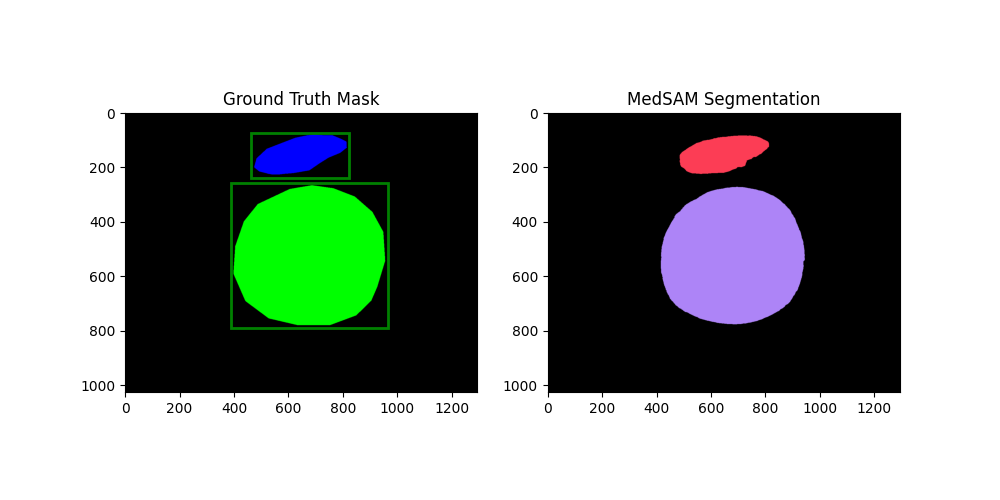

In [21]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Overlay ground truth mask on input image
ax[0].imshow(ground_truth)
ax[0].set_title("Ground Truth Mask")

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Draw bounding box on ground truth mask
    rect = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)

# Load your image (You may need to replace this part with your actual code for loading the image)
image = cv2.imread('.\\assets\\20190911T104437_549.png')

# Load ground truth data (You may need to replace this part with your actual code for loading the ground truth data)
ground_truth = cv2.imread('.\\assets\\20190911T104437_549_mask.png')

# # Initialize an empty mask with the same shape as the input image
img_3c_with_mask = np.zeros_like(image)
# Convert ground truth mask to grayscale (You may need to replace this part with your actual code for processing the ground truth mask)
ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale mask to separate green areas (ROI) from black areas (background) (You may need to replace this part with your actual code for processing the ground truth mask)
_, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

# Find contours in the mask (You may need to replace this part with your actual code for processing the ground truth mask)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through contours and create bounding box for each contour
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Define margin (adjust as needed)
    margin = 10  # Example: 10 pixels margin

    # Expand the bounding box by the margin
    x_margin = max(x - margin, 0)
    y_margin = max(y - margin, 0)
    w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    # Convert the expanded bounding box coordinates to the format used in MedSAM (x_min, y_min, x_max, y_max)
    box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])

    if len(image.shape) == 2:
        img_3c = np.repeat(image[:, :, None], 3, axis=-1)
    else:
        img_3c = image
    H, W, _ = img_3c.shape
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    #print("Using device:", device) .. using cuda

    # Transfer box_np to 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W) #used for scores

    # Overlay segmentation mask on input image with random colors
    colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
    unique_labels = np.unique(medsam_seg)
    for label in unique_labels:
        if label == 0:
            continue
        mask = np.zeros_like(medsam_seg)
        mask[medsam_seg == label] = 255
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        color = random.choice(colors)
        mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
        img_3c_with_mask += mask_rgb
    ax[1].imshow(img_3c_with_mask)

ax[1].set_title("MedSAM Segmentation")

plt.show()


### Segmetnation all dataset

In [22]:
# import os
# import random
# import shutil
# import cv2
# import numpy as np
# import torch
# from skimage import transform
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# 
# # Define input and mask folders for the test set
# input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\images\test'
# mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\masks\test'
# 
# # Define output folder for segmented images
# output_segmentation_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images_1'
# os.makedirs(output_segmentation_folder, exist_ok=True)
# 
# # Sort images and masks based on numerical index
# images = sorted(os.listdir(input_folder), key=lambda x: int(x.split('_')[-1].split('.')[0]))
# masks = sorted(os.listdir(mask_folder), key=lambda x: int(x.split('_')[-2]))
# 
# 
# # Overwrite the contents of the segmented images folder
# shutil.rmtree(output_segmentation_folder)  # Delete the existing segmented images folder
# os.makedirs(output_segmentation_folder, exist_ok=True)  # Recreate the folder
# 
# 
# # Traverse through each image in the test set
# for i, (image_name, mask_name) in enumerate(zip(images, masks)):
#     image_path = os.path.join(input_folder, image_name)
#     mask_path = os.path.join(mask_folder, mask_name)
#     
#     # Load input image
#     image = cv2.imread(image_path)
#     
#     # Load ground truth mask
#     ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# 
#     # Convert the image to the format expected by MedSAM (1024x1024)
#     img_1024 = transform.resize(image, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
#     img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0)
#     
#     # Load MedSAM model (Replace this with your actual code for loading the model)
#     # medsam_model = load_medsam_model()  # You need to implement this function
#     # Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
#     _, mask = cv2.threshold(ground_truth, 50, 255, cv2.THRESH_BINARY)
# 
#     # Find contours in the mask
#     #contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 
#     # Define bounding box parameters
#     contours, _ = cv2.findContours(ground_truth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         margin = 10  # Example: 10 pixels margin
#         x_margin = max(x - margin, 0)
#         y_margin = max(y - margin, 0)
#         w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
#         h_margin = min(h + 2 * margin, image.shape[0] - y_margin)
#         box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])
#         H, W, _ = img_1024.shape
#         box_1024 = box_np / np.array([W, H, W, H]) * 1024
#         
#         # Perform inference with MedSAM model
#         with torch.no_grad():
#             image_embedding = medsam_model.image_encoder(img_1024_tensor.to(device))  # (1, 256, 64, 64)
#             medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)  # Used for scores
# 
#         # Overlay segmentation mask on input image with random colors
#         img_3c_with_mask = np.zeros_like(image)
#         colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
#         unique_labels = np.unique(medsam_seg)
#         for label in unique_labels:
#             if label == 0:
#                 continue
#             mask = np.zeros_like(medsam_seg)
#             mask[medsam_seg == label] = 255
#             mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#             color = random.choice(colors)
#             mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
#             # Resize mask_rgb to match the shape of img_3c_with_mask
#             mask_rgb_resized = cv2.resize(mask_rgb, (img_3c_with_mask.shape[1], img_3c_with_mask.shape[0]))
#             
#             # Add the resized mask to img_3c_with_mask
#             img_3c_with_mask += mask_rgb_resized
#         
#         # Plotting
#         fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# 
#         # Plot input image with ground truth mask
#         ax[0].imshow(image)
#         ax[0].imshow(ground_truth, alpha=0.3, cmap='gray')
#         ax[0].set_title("Input Image with Ground Truth Mask")
# 
#         # Plot segmented image
#         ax[1].imshow(img_3c_with_mask)
#         ax[1].set_title("Segmentation")
# 
#         # Save the plot as an image
#         output_path = os.path.join(output_segmentation_folder, f"segmented_{i}.png")
#         plt.savefig(output_path)
#         plt.close()
# 
#         break  # If you want to process only the first contour, remove this line
# 
# print("Segmentation of the test set completed.")


In [23]:
# from PIL import Image
# 
# # Choose one mask_enhance image from the train folder
# sample_train_mask_enhance = os.path.join(train_folder, os.listdir(train_folder)[0])
# 
# # Open and display the mask_enhance image
# mask_enhance_image = Image.open(sample_train_mask_enhance)
# mask_enhance_image.show()


In [24]:
# import os
# import random
# import shutil
# import cv2
# import numpy as np
# import torch
# from skimage import transform
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# 
# # Define input and mask folders for the test set
# input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\images\test'
# mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\masks\test'
# 
# # Define output folder for segmented images
# output_segmentation_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images_1'
# os.makedirs(output_segmentation_folder, exist_ok=True)
# 
# # Sort images and masks based on numerical index
# images = sorted(os.listdir(input_folder), key=lambda x: int(x.split('_')[-1].split('.')[0]))
# masks = sorted(os.listdir(mask_folder), key=lambda x: int(x.split('_')[-2]))
# 
# 
# # Overwrite the contents of the segmented images folder
# shutil.rmtree(output_segmentation_folder)  # Delete the existing segmented images folder
# os.makedirs(output_segmentation_folder, exist_ok=True)  # Recreate the folder
# 
# 
# # Traverse through each image in the test set
# for i, (image_name, mask_name) in enumerate(zip(images, masks)):
#     image_path = os.path.join(input_folder, image_name)
#     mask_path = os.path.join(mask_folder, mask_name)
#     
#     # Load input image
#     image = cv2.imread(image_path)
#     
#     # Load ground truth mask
#     ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     
#     # Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
#     _, mask = cv2.threshold(ground_truth, 50, 255, cv2.THRESH_BINARY)
#     
#     # Find contours in the mask
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 
#     # Iterate through each contour
#     for contour in contours:
#         # Create bounding box for each contour
#         x, y, w, h = cv2.boundingRect(contour)
#         margin = 10  # Example: 10 pixels margin
#         x_margin = max(x - margin, 0)
#         y_margin = max(y - margin, 0)
#         w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
#         h_margin = min(h + 2 * margin, image.shape[0] - y_margin)
#         box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])
# 
#         # Prepare the image for MedSAM
#         if len(image.shape) == 2:
#             img_3c = np.repeat(image[:, :, None], 3, axis=-1)
#         else:
#             img_3c = image
#         H, W, _ = img_3c.shape
#         img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
#         img_1024 = (img_1024 - img_1024.min()) / np.clip(
#             img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
#         )  # normalize to [0, 1], (H, W, 3)
#         img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
#         
#         # Load MedSAM model (Replace this with your actual code for loading the model)
#         # medsam_model = load_medsam_model()  # You need to implement this function
# 
#         # Perform inference with MedSAM model
#         with torch.no_grad():
#             image_embedding = medsam_model.image_encoder(img_1024_tensor.to(device))  # (1, 256, 64, 64)
#             medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)  # Used for scores
# 
#         # Overlay segmentation mask on input image with random colors
#         img_3c_with_mask = np.zeros_like(image)
#         colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
#         unique_labels = np.unique(medsam_seg)
#         for label in unique_labels:
#             if label == 0:
#                 continue
#             mask = np.zeros_like(medsam_seg)
#             mask[medsam_seg == label] = 255
#             mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#             color = random.choice(colors)
#             mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
#             # Resize mask_rgb to match the shape of img_3c_with_mask
#             mask_rgb_resized = cv2.resize(mask_rgb, (img_3c_with_mask.shape[1], img_3c_with_mask.shape[0]))
#             
#             # Add the resized mask to img_3c_with_mask
#             img_3c_with_mask += mask_rgb_resized
#         
#         # Plotting
#         fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# 
#         # Plot input image with ground truth mask
#         ax[0].imshow(image)
#         ax[0].imshow(ground_truth, alpha=0.3, cmap='gray')
#         ax[0].set_title("Input Image with Ground Truth Mask")
# 
#         # Plot segmented image
#         ax[1].imshow(img_3c_with_mask)
#         ax[1].set_title("Segmentation")
# 
#         # Save the plot as an image
#         output_path = os.path.join(output_segmentation_folder, f"segmented_{i}.png")
#         plt.savefig(output_path)
#         plt.close()
# 
#         break  # If you want to process only the first contour, remove this line
# 
# print("Segmentation of the test set completed.")


#### Creatig bounding boxes , codigo vale

In [25]:
# import os
# import random
# import shutil
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# 
# # Define input and mask folders for the test set
# input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\images\test'
# mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\masks\test'
# 
# # Define output folder for segmented images
# output_segmentation_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\bound_images'
# os.makedirs(output_segmentation_folder, exist_ok=True)
# 
# # Sort images and masks based on numerical index
# images = sorted(os.listdir(input_folder), key=lambda x: int(x.split('_')[-1].split('.')[0]))
# masks = sorted(os.listdir(mask_folder), key=lambda x: int(x.split('_')[-2]))
# 
# 
# # Overwrite the contents of the segmented images folder
# shutil.rmtree(output_segmentation_folder)  # Delete the existing segmented images folder
# os.makedirs(output_segmentation_folder, exist_ok=True)  # Recreate the folder
# 
# 
# # Traverse through each image in the test set
# for i, (image_name, mask_name) in enumerate(zip(images, masks)):
#     image_path = os.path.join(input_folder, image_name)
#     mask_path = os.path.join(mask_folder, mask_name)
#     
#     # Load input image
#     image = cv2.imread(image_path)
#     
#     # Load ground truth mask
#     ground_truth = cv2.imread(mask_path)
#     
#     # Convert the mask to grayscale
#     ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
#     
#     # Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
#     _, thresh = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)
#     
#     # Find contours in the mask
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     
#     # Iterate through each contour and draw bounding boxes
#     for contour in contours:
#         # Compute the bounding box for each contour
#         x, y, w, h = cv2.boundingRect(contour)
#         
#         # Draw the bounding box on the original image
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
#     
#     # Plotting
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# 
#     # Plot input image with bounding boxes
#     ax[0].imshow(image)
#     ax[0].set_title("Segmented Image with Bounding Boxes")
#     
#     # Plot ground truth mask
#     ax[1].imshow(ground_truth_gray, cmap='gray')
#     ax[1].set_title("Ground Truth Mask")
# 
#     # Save the plot as an image
#     output_path = os.path.join(output_segmentation_folder, f"{image_name.split('.')[0]}_s.png")
#     plt.savefig(output_path)
#     plt.close()
# 
# print("Segmented images with bounding boxes created and saved.")


Trials with left ventricle.. creating bounding boxes


## SEGMENTAITON

In [26]:
# import os
# import random
# import cv2
# import numpy as np
# import torch
# from skimage import transform
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# 
# # Define input and mask folders for the test set
# input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\images\test'
# mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\partitioned_dataset\masks\test'
# 
# # Load your MedSAM model (Replace this with your actual code for loading the model)
# # medsam_model = load_medsam_model()  # You need to implement this function
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
# # Define output folder for segmented images
# output_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images2'
# os.makedirs(output_folder, exist_ok=True)
# 
# # Sort images and masks based on numerical index
# images = sorted(os.listdir(input_folder), key=lambda x: int(x.split('_')[-1].split('.')[0]))
# masks = sorted(os.listdir(mask_folder), key=lambda x: int(x.split('_')[-2]))
# 
# # Visualization
# for image_name, mask_name in zip(images, masks):
#     # Load your image
#     image_path = os.path.join(input_folder, image_name)
#     image = cv2.imread(image_path)
# 
#     # Load ground truth data
#     mask_path = os.path.join(mask_folder, mask_name)
#     ground_truth = cv2.imread(mask_path)
# 
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# 
    # # Overlay ground truth mask on input image
    # ax[0].imshow(ground_truth)
    # ax[0].set_title("Ground Truth Mask")

    # # Convert the mask to grayscale
    # ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)

    # # Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
    # _, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

    # # Check if the mask contains any non-black pixels
    # if np.any(mask):
    #     # Find contours in the mask
    #     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #     # Iterate through contours and create bounding box for each contour
    #     for contour in contours:
    #         x, y, w, h = cv2.boundingRect(contour)

    #         # Define margin
    #         margin = 10

    #         # Expand the bounding box by the margin
    #         x_margin = max(x - margin, 0)
    #         y_margin = max(y - margin, 0)
    #         w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    #         h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    #         # Draw bounding box on ground truth mask
    #         rect = patches.Rectangle((x_margin, y_margin), w_margin, h_margin, linewidth=2, edgecolor='g', facecolor='none')
    #         ax[0].add_patch(rect)

    #     # Initialize an empty mask with the same shape as the input image
    #     img_3c_with_mask = np.zeros_like(image)

    #     # Convert ground truth mask to grayscale
    #     ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)

    #     # Threshold the grayscale mask to separate green areas (ROI) from black areas (background)
    #     _, mask = cv2.threshold(ground_truth_gray, 50, 255, cv2.THRESH_BINARY)

    #     # Find contours in the mask
    #     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #     # Iterate through contours and create bounding box for each contour
    #     for contour in contours:
    #         x, y, w, h = cv2.boundingRect(contour)

    #         # Define margin
    #         margin = 10

    #         # Expand the bounding box by the margin
    #         x_margin = max(x - margin, 0)
    #         y_margin = max(y - margin, 0)
    #         w_margin = min(w + 2 * margin, image.shape[1] - x_margin)
    #         h_margin = min(h + 2 * margin, image.shape[0] - y_margin)

    #         # Convert the expanded bounding box coordinates to the format used in MedSAM (x_min, y_min, x_max, y_max)
    #         box_np = np.array([[x_margin, y_margin, x_margin + w_margin, y_margin + h_margin]])

    #         # Convert image to 1024x1024 and normalize
    #         if len(image.shape) == 2:
    #             img_3c = np.repeat(image[:, :, None], 3, axis=-1)
    #         else:
    #             img_3c = image
    #         H, W, _ = img_3c.shape
    #         img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    #         img_1024 = (img_1024 - img_1024.min()) / np.clip(
    #             img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    #         )  # normalize to [0, 1], (H, W, 3)
    #         img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    #         # Transfer box_np to 1024x1024 scale
    #         box_1024 = box_np / np.array([W, H, W, H]) * 1024
# 
#             # Perform inference with MedSAM model
#             with torch.no_grad():
#                 image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)
# 
#             medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W) #used for scores
# 
#             # Overlay segmentation mask on input image with random colors
#             colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(256)]
#             unique_labels = np.unique(medsam_seg)
#             for label in unique_labels:
#                 if label == 0:
#                     continue
#                 mask = np.zeros_like(medsam_seg)
#                 mask[medsam_seg == label] = 255
#                 mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#                 color = random.choice(colors)
#                 mask_rgb[np.where((mask_rgb == [255, 255, 255]).all(axis=2))] = color
#                 img_3c_with_mask += mask_rgb
#             ax[1].imshow(img_3c_with_mask)
# 
# 
#         ax[1].set_title("MedSAM Segmentation")
#     else:
#         # If the mask is entirely black, set the segmented image to black
#         img_black = np.zeros_like(image)
#         ax[1].imshow(img_black)
#         ax[1].set_title("MedSAM Segmentation")
# 
#     # Save the segmented image with bounding box
#     output_path = os.path.join(output_folder, f"{image_name.split('.')[0]}_s.png")
#     plt.savefig(output_path)
#     plt.close()
# 
# print("Segmented images with bounding boxes saved.")


## DICE SCORE

In [27]:
# # Crop the ground truth mask and the MedSAM segmentation to the bounding box region
# ground_truth_roi = ground_truth_gray[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# medsam_seg_roi = medsam_seg[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# 
# # Compute intersection and union of the masks within the bounding box
# intersection = np.logical_and(ground_truth_roi > 0, medsam_seg_roi > 0)
# union = np.logical_or(ground_truth_roi > 0, medsam_seg_roi > 0)
# 
# # Compute Dice score
# dice_score = 2 * np.sum(intersection) / (np.sum(ground_truth_roi > 0) + np.sum(medsam_seg_roi > 0))
# 
# print("Dice Score:", dice_score)


### DICE SCORE FOR ALL IAMGES

In [28]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# 
# # Define folder paths for segmented images and ground truth masks
# segmented_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images2'
# 
# # Get list of filenames in the segmented images folder
# segmented_filenames = sorted(os.listdir(segmented_folder))
# 
# # Initialize list to store Dice scores
# dice_scores = []
# 
# # Iterate through segmented images and corresponding ground truth masks
# for filename in segmented_filenames:
#     # Load segmented image
#     image_path = os.path.join(segmented_folder, filename)
#     image = cv2.imread(image_path)
# 
#     # Load ground truth mask
#     mask_path = os.path.join(segmented_folder, filename.replace('_s.png', '_gt.png'))
#     ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# 
#     # Crop the images to the bounding box region (you need to define the bounding box coordinates)
#     # Here, we assume that you have the bounding box coordinates for cropping
#     # Adjust the bounding box coordinates based on your requirement
#     # This step is necessary if the ground truth and segmented images are not of the same size
#     # Adjust the bounding box coordinates based on your requirement
#     # This step is necessary if the ground truth and segmented images are not of the same size
# 
#     # Compute intersection and union of the masks within the bounding box
#     intersection = np.logical_and(ground_truth > 0, image > 0)
#     union = np.logical_or(ground_truth > 0, image > 0)
# 
#     # Compute Dice score
#     dice_score = 2 * np.sum(intersection) / (np.sum(ground_truth > 0) + np.sum(image > 0))
# 
#     # Append Dice score to the list
#     dice_scores.append(dice_score)
# 
# # Calculate average Dice score
# average_dice_score = np.mean(dice_scores)
# 
# print("Average Dice Score:", average_dice_score)


In [29]:
import os
import cv2
import numpy as np

# Define folder path for segmented images
segmented_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images2'

# Get list of filenames in the segmented images folder
segmented_filenames = sorted(os.listdir(segmented_folder))

# Initialize list to store Dice scores
dice_scores = []

# Iterate through segmented images
for filename in segmented_filenames:
    # Load the segmented image
    image_path = os.path.join(segmented_folder, filename)
    image = cv2.imread(image_path)

    # Split the image into ground truth mask and segmentation result
    height, width, _ = image.shape
    ground_truth = image[:, :width//2, :]
    segmentation = image[:, width//2:, :]

    # Convert to grayscale if necessary
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    segmentation_gray = cv2.cvtColor(segmentation, cv2.COLOR_BGR2GRAY)

    # Convert segmented image to binary masks
    _, ground_truth_mask = cv2.threshold(ground_truth_gray, 1, 255, cv2.THRESH_BINARY)
    _, segmentation_mask = cv2.threshold(segmentation_gray, 1, 255, cv2.THRESH_BINARY)

    # Compute intersection and union of the masks
    intersection = np.logical_and(ground_truth_mask > 0, segmentation_mask > 0)
    union = np.logical_or(ground_truth_mask > 0, segmentation_mask > 0)

    # Compute Dice score
    dice_score = 2 * np.sum(intersection) / (np.sum(ground_truth_mask > 0) + np.sum(segmentation_mask > 0))

    # Append Dice score to the list
    dice_scores.append(dice_score)

# Calculate average Dice score
average_dice_score = np.mean(dice_scores)

print("Average Dice Score:", average_dice_score)


Average Dice Score: 0.8113106611853925


In [30]:
##Dice Score: 0.9521258685604089 with 549

## JACCARD

In [31]:
# # Crop the ground truth mask and the MedSAM segmentation to the bounding box region
# ground_truth_roi = ground_truth_gray[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# medsam_seg_roi = medsam_seg[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# 
# # Compute intersection and union of the masks within the bounding box
# intersection = np.logical_and(ground_truth_roi > 0, medsam_seg_roi > 0)
# union = np.logical_or(ground_truth_roi > 0, medsam_seg_roi > 0)
# 
# # Compute Jaccard score
# jaccard_score = np.sum(intersection) / np.sum(union)
# 
# print("Jaccard Score:", jaccard_score)


## ACCURACY AND SESITIVITY

In [32]:
# # Crop the ground truth mask and the MedSAM segmentation to the bounding box region
# ground_truth_roi = ground_truth_gray[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# medsam_seg_roi = medsam_seg[y_margin:y_margin + h_margin, x_margin:x_margin + w_margin]
# 
# # True Positives (TP): Intersection of ground truth and segmentation
# TP = np.sum(np.logical_and(ground_truth_roi > 0, medsam_seg_roi > 0))
# 
# # False Negatives (FN): Regions in ground truth not covered by segmentation
# FN = np.sum(np.logical_and(ground_truth_roi > 0, medsam_seg_roi == 0))
# 
# # False Positives (FP): Regions in segmentation not covered by ground truth
# FP = np.sum(np.logical_and(ground_truth_roi == 0, medsam_seg_roi > 0))
# 
# # True Negatives (TN): Regions outside of both ground truth and segmentation
# TN = np.sum(np.logical_and(ground_truth_roi == 0, medsam_seg_roi == 0))
# 
# # Accuracy: (TP + TN) / (TP + TN + FP + FN)
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# 
# # Sensitivity (True Positive Rate): TP / (TP + FN)
# sensitivity = TP / (TP + FN)
# 
# print("Accuracy:", accuracy)
# print("Sensitivity:", sensitivity)


## TABLE OF ALL SCORES

In [33]:
# from tabulate import tabulate
# 
# # Define scores
# scores = {
#     "Accuracy": accuracy,
#     "Sensitivity": sensitivity,
#     "Dice Score": dice_score,
#     "Jaccard Score": jaccard_score
# }
# 
# # Format scores for table display
# table_data = [(metric, f"{score:.4f}" if isinstance(score, float) else score) for metric, score in scores.items()]
# 
# # Display table
# print(tabulate(table_data, headers=["Metric", "Score"], tablefmt="fancy_grid"))


In [34]:
### other scores and table of all scores

In [35]:
import os
import cv2
import numpy as np

# Define folder path for segmented images
segmented_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images2'

# Get list of filenames in the segmented images folder
segmented_filenames = sorted(os.listdir(segmented_folder))

# Initialize lists to store evaluation metrics
jaccard_indices = []
accuracies = []
sensitivities = []

# Iterate through segmented images
for filename in segmented_filenames:
    # Load the segmented image
    image_path = os.path.join(segmented_folder, filename)
    image = cv2.imread(image_path)

    # Split the image into ground truth mask and segmentation result
    height, width, _ = image.shape
    ground_truth = image[:, :width//2, :]
    segmentation = image[:, width//2:, :]

    # Convert to grayscale if necessary
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    segmentation_gray = cv2.cvtColor(segmentation, cv2.COLOR_BGR2GRAY)

    # Convert segmented image to binary masks
    _, ground_truth_mask = cv2.threshold(ground_truth_gray, 1, 255, cv2.THRESH_BINARY)
    _, segmentation_mask = cv2.threshold(segmentation_gray, 1, 255, cv2.THRESH_BINARY)

    # Compute True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    TP = np.sum(np.logical_and(ground_truth_mask > 0, segmentation_mask > 0))
    TN = np.sum(np.logical_and(ground_truth_mask == 0, segmentation_mask == 0))
    FP = np.sum(np.logical_and(ground_truth_mask == 0, segmentation_mask > 0))
    FN = np.sum(np.logical_and(ground_truth_mask > 0, segmentation_mask == 0))

    # Calculate Jaccard Index
    jaccard_index = TP / (TP + FP + FN)

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate Sensitivity (True Positive Rate)
    sensitivity = TP / (TP + FN)

    # Append metrics to the respective lists
    jaccard_indices.append(jaccard_index)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)

# Calculate average metrics
average_jaccard_index = np.mean(jaccard_indices)
average_accuracy = np.mean(accuracies)
average_sensitivity = np.mean(sensitivities)

print("Average Jaccard Index:", average_jaccard_index)
print("Average Accuracy:", average_accuracy)
print("Average Sensitivity:", average_sensitivity)


Average Jaccard Index: 0.6828748411137199
Average Accuracy: 0.7513162507645259
Average Sensitivity: 0.8062944385388355


In [36]:
import pandas as pd

# Calculate the average scores
average_dice_score = np.mean(dice_scores)
average_jaccard_index = np.mean(jaccard_indices)
average_accuracy = np.mean(accuracies)
average_sensitivity = np.mean(sensitivities)

# Create DataFrames for individual scores
dice_df = pd.DataFrame({"Metric": ["Dice Score"] * len(dice_scores), "Score": dice_scores})
jaccard_df = pd.DataFrame({"Metric": ["Jaccard Index"] * len(jaccard_indices), "Score": jaccard_indices})
accuracy_df = pd.DataFrame({"Metric": ["Accuracy"] * len(accuracies), "Score": accuracies})
sensitivity_df = pd.DataFrame({"Metric": ["Sensitivity"] * len(sensitivities), "Score": sensitivities})

# Concatenate all DataFrames
combined_df = pd.concat([dice_df, jaccard_df, accuracy_df, sensitivity_df])

# Calculate the average score for each metric
average_scores = combined_df.groupby("Metric").mean().reset_index()

# Display the final DataFrame
print(average_scores)


          Metric     Score
0       Accuracy  0.751316
1     Dice Score  0.811311
2  Jaccard Index  0.682875
3    Sensitivity  0.806294


# Visualizations

ValueError: num must be an integer with 1 <= num <= 2, not 3

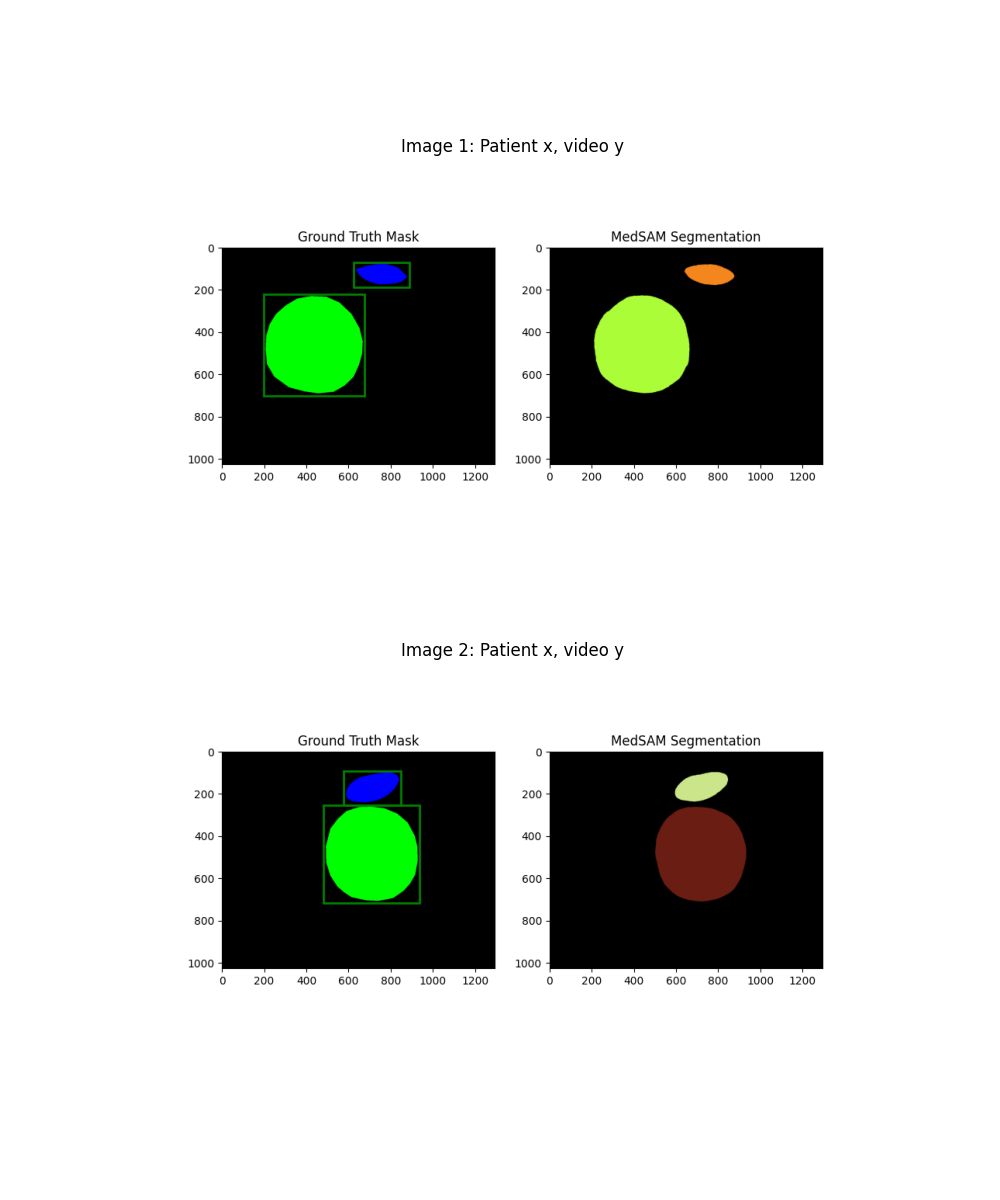

In [50]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Define folder path for segmented images
segmented_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\MedSAM\up_dataset\us_data\segmented_images2'

# Get list of filenames in the segmented images folder
segmented_filenames = sorted(os.listdir(segmented_folder))

# Randomly select 4 images
random_images = random.sample(segmented_filenames, 4)

# Plot the randomly selected images
plt.figure(figsize=(10, 12))  # Adjust figure size for 3 rows
for i, filename in enumerate(random_images, 1):
    # Load the segmented image
    image_path = os.path.join(segmented_folder, filename)
    image = cv2.imread(image_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.subplot(2, 1, i)  # Plot in 3 rows and 1 column
    plt.imshow(image)
    plt.title(f"Image {i}: Patient x, video y")  # Display filename as title
    plt.axis('off')

    # Adjust aspect ratio to make images more square-like
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
